Found 3250 images belonging to 82 classes.
Loading model...

Evaluating model...
102/102 [==============================] - 7s 67ms/step - loss: 1.0058 - accuracy: 0.8095

Validation Accuracy: 80.95%
Validation Loss: 1.0058
102/102 [==============================] - 7s 67ms/step


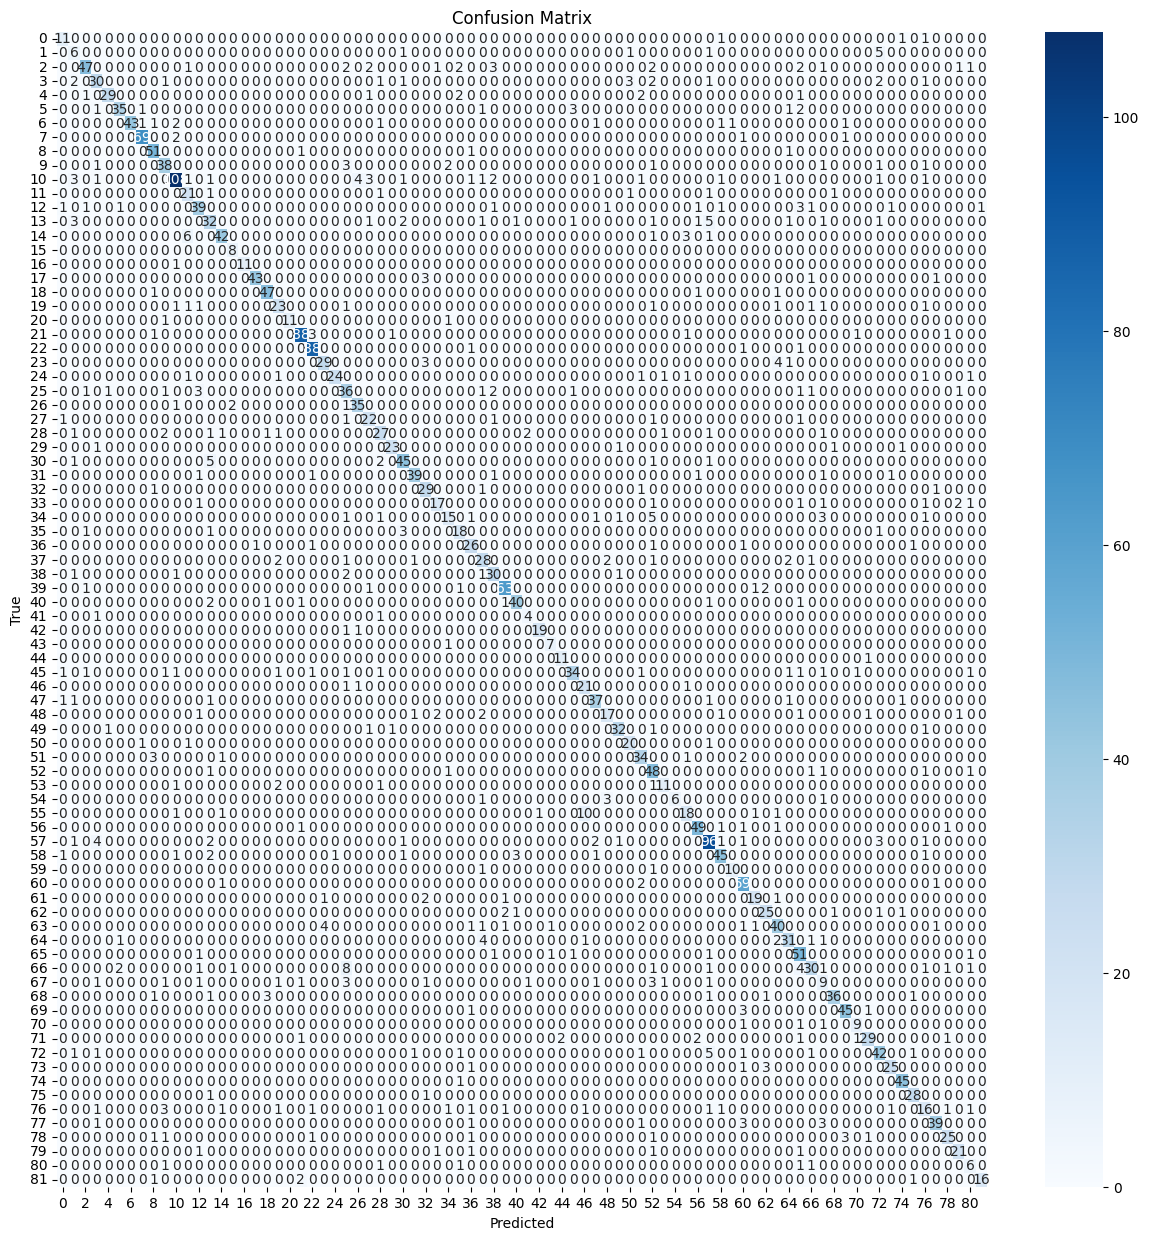


Classification Report:
                                                                            precision    recall  f1-score   support

Akarna_Dhanurasana                                                             0.688    0.786    0.733       14
Bharadvaja's_Twist_pose_or_Bharadvajasana_I_                                   0.300    0.429    0.353       14
Boat_Pose_or_Paripurna_Navasana_                                               0.887    0.723    0.797       65
Bound_Angle_Pose_or_Baddha_Konasana_                                           0.698    0.682    0.690       44
Bow_Pose_or_Dhanurasana_                                                       0.935    0.806    0.866       36
Bridge_Pose_or_Setu_Bandha_Sarvangasana_                                       0.897    0.795    0.843       44
Camel_Pose_or_Ustrasana_                                                       1.000    0.827    0.905       52
Cat_Cow_Pose_or_Marjaryasana_                                              

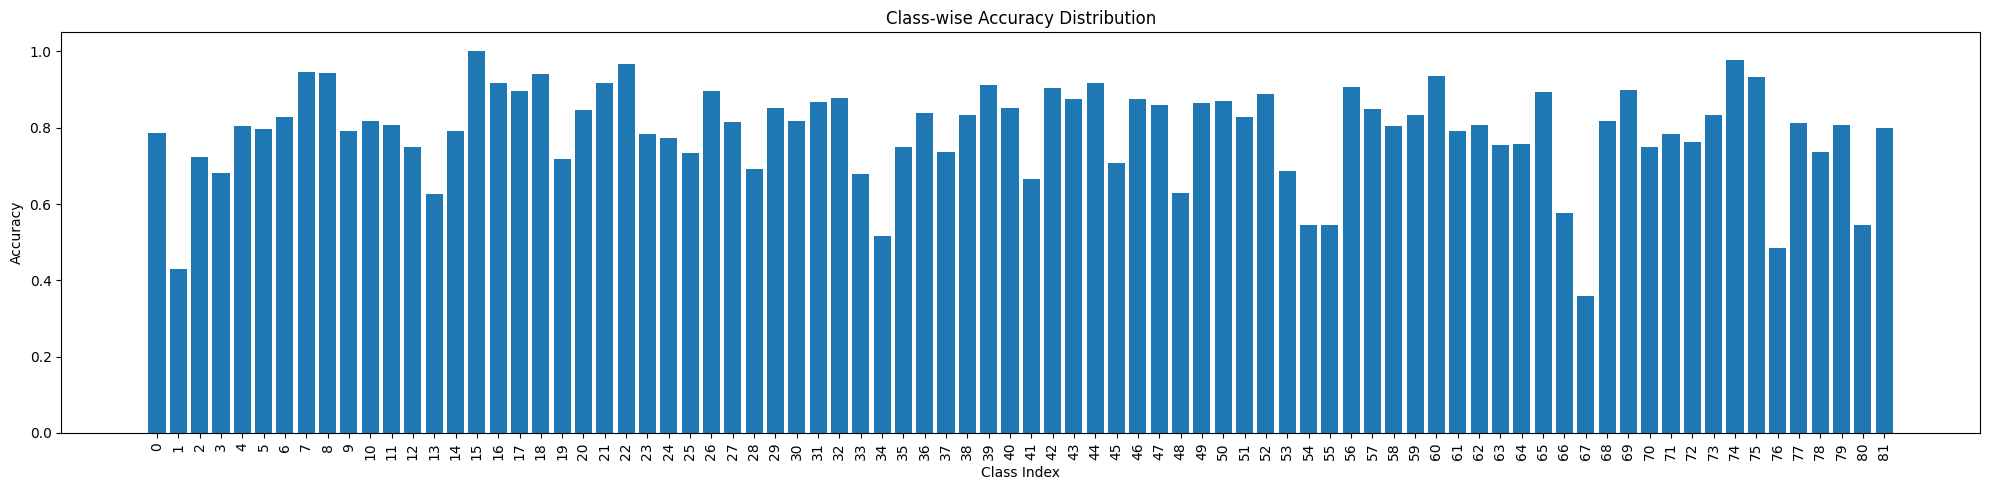


Top-3 Accuracy: 89.38%

Total incorrect predictions: 619

Top 10 most common prediction errors:
Side_Crane_(Crow)_Pose_or_Parsva_Bakasana_ -> Pose_Dedicated_to_the_Sage_Koundinya_or_Eka_Pada_Koundinyanasana_I_and_II: 10 instances
Supta_Virasana_Vajrasana -> Fish_Pose_or_Matsyasana_: 8 instances
Crane_(Crow)_Pose_or_Bakasana_ -> Cockerel_Pose: 6 instances
Bharadvaja's_Twist_pose_or_Bharadvajasana_I_ -> Virasana_or_Vajrasana: 5 instances
Cow_Face_Pose_or_Gomukhasana_ -> Sitting pose 1 (normal): 5 instances
Half_Lord_of_the_Fishes_Pose_or_Ardha_Matsyendrasana_ -> Cow_Face_Pose_or_Gomukhasana_: 5 instances
Head-to-Knee_Forward_Bend_pose_or_Janu_Sirsasana_ -> Seated_Forward_Bend_pose_or_Paschimottanasana_: 5 instances
Virasana_or_Vajrasana -> Sitting pose 1 (normal): 5 instances
Cobra_Pose_or_Bhujangasana_ -> Four-Limbed_Staff_Pose_or_Chaturanga_Dandasana_: 4 instances
Feathered_Peacock_Pose_or_Pincha_Mayurasana_ -> Supported_Headstand_pose_or_Salamba_Sirsasana_: 4 instances


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 设置数据生成器
data_gen = ImageDataGenerator(
    rescale=1.0/255,  # 只进行归一化，不做数据增强
    validation_split=0.2
)

# 数据路径
data_dir = r'C:\Users\Anderson\Documents\GitHub\COMP9444_project\Dataset\Yoga-82\yoga_dataset_links_skeleton'

# 生成验证集
validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(256, 256),  # 确保与训练时的尺寸一致
    batch_size=32,
    class_mode='sparse',     # 使用sparse标签而不是categorical
    subset='validation',
    shuffle=False            # 评估时不打乱数据
)

def print_classification_report(y_true, y_pred, class_names):
    """格式化打印分类报告"""
    # 获取最长的类名长度
    max_name_length = max(len(name) for name in class_names)
    # 确保至少有40个字符的空间
    name_width = max(max_name_length + 2, 40)
    
    # 生成报告
    report = classification_report(
        y_true, 
        y_pred,
        target_names=class_names,
        digits=3,  # 控制小数点位数
        zero_division=0
    )
    
    # 分行处理并重新格式化
    lines = report.split('\n')
    formatted_lines = []
    
    # 处理每一行
    for line in lines:
        if not line.strip():
            formatted_lines.append(line)
            continue
            
        # 处理标题行
        if 'precision' in line:
            formatted_lines.append(f"{'':>{name_width}} {line.strip()}")
            continue
            
        # 处理数据行
        if line.strip() and any(c.isdigit() for c in line):
            parts = line.strip().split()
            if len(parts) == 5:  # 常规类别行
                name = ' '.join(parts[:-4])
                metrics = parts[-4:]
                formatted_line = f"{name:<{name_width}} {' '.join(f'{m:>8}' for m in metrics)}"
                formatted_lines.append(formatted_line)
            elif len(parts) == 4:  # accuracy/macro avg/weighted avg 行
                if 'accuracy' in line:
                    formatted_lines.append(f"{'accuracy':<{name_width}} {' ':>8} {' ':>8} {parts[1]:>8} {parts[2]:>8}")
                else:
                    name = ' '.join(parts[:-3])
                    metrics = parts[-3:]
                    formatted_lines.append(f"{name:<{name_width}} {' '.join(f'{m:>8}' for m in metrics)} {' ':>8}")
    
    # 打印格式化后的报告
    print('\nClassification Report:')
    print('\n'.join(formatted_lines))

def evaluate_model_comprehensive(model_path):
    """全面评估模型性能"""
    print("Loading model...")
    model = load_model(model_path)
    
    print("\nEvaluating model...")
    # 计算总体性能指标
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    
    # 获取预测结果
    validation_generator.reset()
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes
    
    # 计算并显示混淆矩阵
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 生成详细的分类报告
    class_names = list(validation_generator.class_indices.keys())
    print_classification_report(y_true, y_pred, class_names)  # 使用新的打印函数
    
    # 计算每个类别的准确率
    class_accuracies = []
    for i in range(len(class_names)):
        mask = (y_true == i)
        if np.sum(mask) > 0:  # 确保有该类别的样本
            class_acc = np.mean(y_pred[mask] == i)
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)
    
    # 绘制类别准确率分布
    plt.figure(figsize=(20, 5))
    plt.bar(range(len(class_accuracies)), class_accuracies)
    plt.title('Class-wise Accuracy Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(class_accuracies)), rotation=90)
    plt.tight_layout()
    plt.show()
    
    # 计算Top-3准确率
    top3_acc = 0
    for i in range(len(y_true)):
        if y_true[i] in np.argsort(predictions[i])[-3:]:
            top3_acc += 1
    top3_acc /= len(y_true)
    print(f"\nTop-3 Accuracy: {top3_acc*100:.2f}%")
    
    # 分析错误预测
    incorrect_indices = np.where(y_pred != y_true)[0]
    print(f"\nTotal incorrect predictions: {len(incorrect_indices)}")
    
    if len(incorrect_indices) > 0:
        error_distribution = {}
        for idx in incorrect_indices:
            true_class = class_names[y_true[idx]]
            pred_class = class_names[y_pred[idx]]
            error_pair = f"{true_class} -> {pred_class}"
            error_distribution[error_pair] = error_distribution.get(error_pair, 0) + 1
        
        print("\nTop 10 most common prediction errors:")
        sorted_errors = sorted(error_distribution.items(), key=lambda x: x[1], reverse=True)
        for error_pair, count in sorted_errors[:10]:
            print(f"{error_pair}: {count} instances")

# 使用示例
if __name__ == "__main__":
    model_path = 'yoga_pose_model_final.h5'  # 替换为您的模型路径
    evaluate_model_comprehensive(model_path)